# 1. Baseline Machine Learning Classification Model

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Define data directories
data_dir = r'C:\Users\kcpey\Documents\jujuAI\INF6422E-Lab2'  # Update with your local path


# Data transformation
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Adding vertical flip
    transforms.RandomRotation(20),    # Adding random rotation
    transforms.RandomAffine(15),      # Adding random affine transformation
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [28]:
# Load datasets
full_dataset = datasets.CIFAR10(root=data_dir, transform=data_transform)

# Split the dataset into train, validation, and test sets
# train_size = int(0.7 * len(full_dataset))
# val_size = int(0.15 * len(full_dataset))
# test_size = len(full_dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size]) #pas bon -> stratified split!!
# targets = full_dataset
# print(targets)

# 1. Récupérer tous les labels pour la stratification
# Note : Pour CIFAR10, les targets sont stockées dans .targets
targets = full_dataset.targets

# 2. Premier split : On sépare 70% pour le train et 30% pour le reste (val + test)
train_idx, rem_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    stratify=targets,
    random_state=42
)

# 3. Deuxième split : On sépare le reste en deux (15% val, 15% test du total)
# Puisque 15% est la moitié de 30%, on utilise test_size=0.5
val_idx, test_idx = train_test_split(
    rem_idx,
    test_size=0.5,
    stratify=[targets[i] for i in rem_idx],
    random_state=42
)

# 4. Créer les Subsets PyTorch
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [29]:
class SimpleCNN(nn.Module): #print loss (voir msg Malik) -> si ca converge, faut changer modele si converge pas augmenter le nb epoch/lr, si loss diminue et apres augmente -> modele trop complexe et il overfit donc enlever des couches (baisser lr??) pas toucher padding au début (pas tres important)
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__() #pt in/out channel, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        #self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # Updated to match the expected input size
        #self.fc1 = nn.Linear(512 * 1 * 1, 512)  # Updated to match the expected input size after 5 conv layers
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        #x = self.pool(self.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Check the model architecture
model = SimpleCNN(num_classes=10)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [30]:
import torch
print("Torch version:", torch.__version__)
print("CUDA in torch:", torch.version.cuda)


# Check if GPU is available
print(torch.cuda.is_available())

Torch version: 2.5.1
CUDA in torch: 11.8
True


In [31]:
# We made a function from the code to make later use easier
def train_model(model, train_loader, val_loader, num_epochs=10):

    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #pt on touche au lr (learning rate -> à quel point on reajuste en fonction de lerreur)

    # Training loop
    # num_epochs = 10

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        class_correct = defaultdict(int)
        class_total = defaultdict(int)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for i in range(len(labels)):
                    label = labels[i].item()
                    pred = predicted[i].item()
                    if label == pred:
                        class_correct[label] += 1
                    class_total[label] += 1

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        for class_idx in range(len(class_total)):
            accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
            print(f"Validation Accuracy for class {class_idx}: {accuracy:.2f}%")
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss (CNN)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

Epoch 1/50, Train Loss: 2.0037, Val Loss: 1.7594, Val Accuracy: 34.61%
Validation Accuracy for class 0: 60.67%
Validation Accuracy for class 1: 58.53%
Validation Accuracy for class 2: 14.53%
Validation Accuracy for class 3: 10.53%
Validation Accuracy for class 4: 21.47%
Validation Accuracy for class 5: 40.93%
Validation Accuracy for class 6: 52.00%
Validation Accuracy for class 7: 41.20%
Validation Accuracy for class 8: 22.67%
Validation Accuracy for class 9: 23.60%
Epoch 2/50, Train Loss: 1.7220, Val Loss: 1.6114, Val Accuracy: 41.48%
Validation Accuracy for class 0: 35.47%
Validation Accuracy for class 1: 50.67%
Validation Accuracy for class 2: 30.40%
Validation Accuracy for class 3: 14.27%
Validation Accuracy for class 4: 37.60%
Validation Accuracy for class 5: 30.67%
Validation Accuracy for class 6: 58.13%
Validation Accuracy for class 7: 47.20%
Validation Accuracy for class 8: 50.67%
Validation Accuracy for class 9: 59.73%
Epoch 3/50, Train Loss: 1.6018, Val Loss: 1.5277, Val Accu

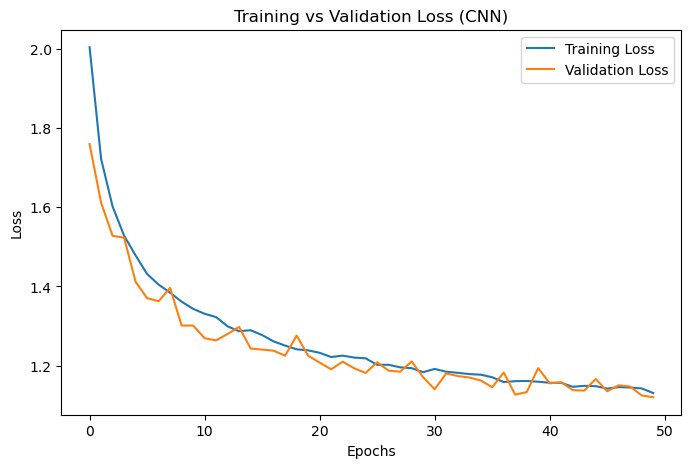

In [32]:
# train the model

model = train_model(model, train_loader, val_loader, num_epochs=50)

In [33]:
# Save the trained model
torch.save(model.state_dict(), 'cnn_project_4cnn.pth')
print("Model saved as cnn_project_4cnn.pth")

Model saved as cnn_project_4cnn.pth


In [34]:
# Load the trained model
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('cnn_project_4cnn.pth'))

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

# Evaluate on the test set
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    for class_idx in range(len(class_total)):
        accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
        print(f"Test Accuracy for class {class_idx}: {accuracy:.2f}%")

evaluate_model(model, test_loader)

C:\Users\kcpey\AppData\Local\Temp\ipykernel_31316\3051133618.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_project_4cnn.pth'))


Test Accuracy: 60.93%
Test Accuracy for class 0: 64.00%
Test Accuracy for class 1: 77.20%
Test Accuracy for class 2: 49.60%
Test Accuracy for class 3: 29.87%
Test Accuracy for class 4: 52.93%
Test Accuracy for class 5: 56.67%
Test Accuracy for class 6: 71.33%
Test Accuracy for class 7: 64.40%
Test Accuracy for class 8: 74.53%
Test Accuracy for class 9: 68.80%


In [35]:
# Get predictions and calculate probabilities for ROC and Precision-Recall curves
# Made as function to make later use easier
def get_predictions_and_probabilities(model, test_loader):
    all_labels = []
    all_outputs = []
    all_outputs_proba = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(predicted.cpu().numpy())
            all_outputs_proba.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    all_outputs_proba = np.array(all_outputs_proba)

    # Get class names from the original dataset
    class_names = full_dataset.classes

    return all_labels, all_outputs, all_outputs_proba, class_names

all_labels, all_outputs, all_outputs_proba, class_names = get_predictions_and_probabilities(model, test_loader)

Normalized confusion matrix


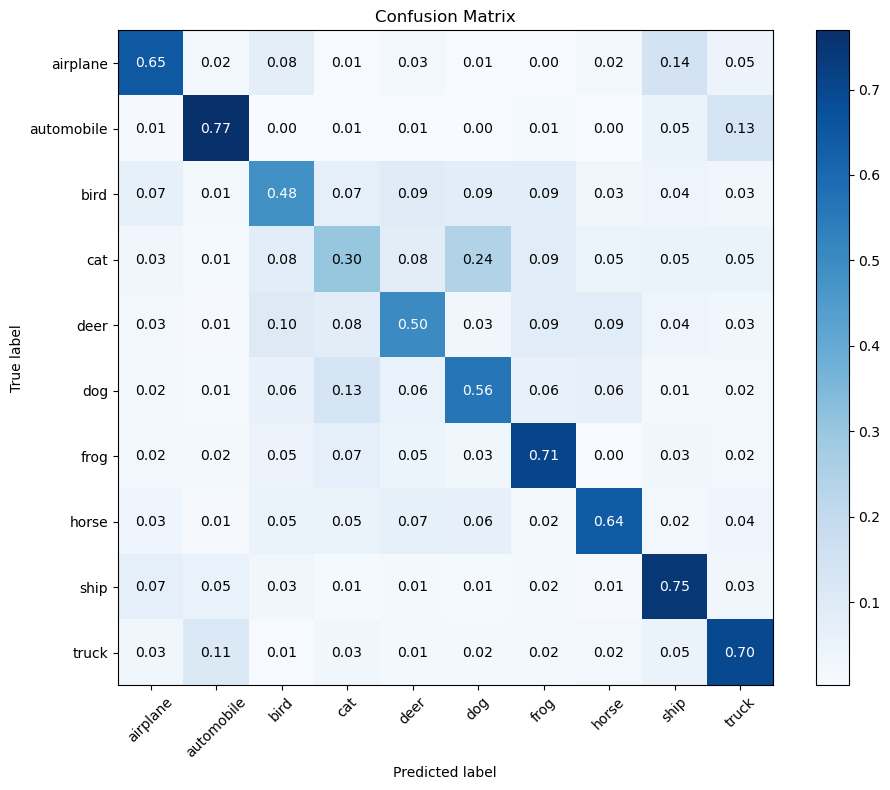

Classification Report:
               precision    recall  f1-score   support

    airplane       0.68      0.65      0.66       750
  automobile       0.75      0.77      0.76       750
        bird       0.51      0.48      0.50       750
         cat       0.40      0.30      0.34       750
        deer       0.55      0.50      0.53       750
         dog       0.53      0.56      0.55       750
        frog       0.64      0.71      0.67       750
       horse       0.68      0.64      0.66       750
        ship       0.62      0.75      0.68       750
       truck       0.64      0.70      0.67       750

    accuracy                           0.61      7500
   macro avg       0.60      0.61      0.60      7500
weighted avg       0.60      0.61      0.60      7500



In [36]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_outputs)
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Classification Report
class_report = classification_report(all_labels, all_outputs, target_names=class_names, zero_division=0)
print("Classification Report:\n", class_report)

# Binarize labels for ROC and Precision-Recall curves
y_test_binarized = label_binarize(all_labels, classes=np.arange(len(class_names)))
if y_test_binarized.shape[1] == 1:
    y_test_binarized = np.hstack([1 - y_test_binarized, y_test_binarized])

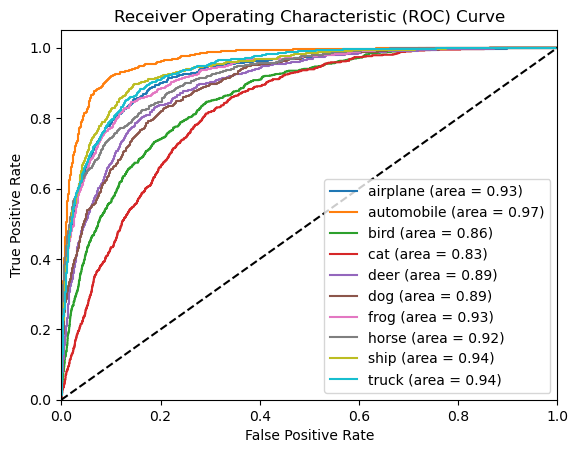

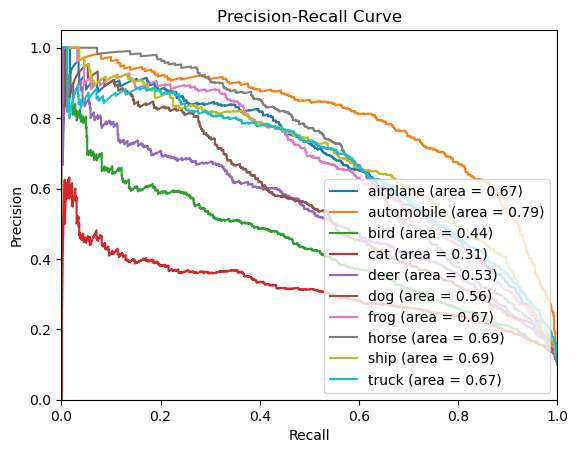

In [37]:
def plot_roc_curve_multiclass(y_true, y_pred_proba, n_classes, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve_multiclass(y_true, y_pred_proba, n_classes, class_names):
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'{class_names[i]} (area = {pr_auc[i]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for each class
plot_roc_curve_multiclass(y_test_binarized, all_outputs_proba, len(class_names), class_names)

# Plot Precision-Recall curve for each class
plot_precision_recall_curve_multiclass(y_test_binarized, all_outputs_proba, len(class_names), class_names)

# 2. Adversarial Evasion Attacks (Test-Time Threats)
## 2.1 FGSM Attack Implementation


In [61]:
# FGSM Attack Implementation

def fgsm_attack(image, epsilon, data_grad):
    # Sign of gradient
    sign_grad = data_grad.sign()
    # Create adversarial image
    perturbed_image = image + epsilon * sign_grad
    # Clip to valid pixel range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # /!\ Note: Since the images are normalized, clipping to [0, 1] is not correct.
    # Had weird results when vizualizing the perturbation otherwise 

    return perturbed_image


In [62]:
## Apply FGSM attack on a sample from the test set

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

images.requires_grad = True

outputs = model(images)

criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)

model.zero_grad()
loss.backward()

data_grad = images.grad.data

epsilon = [0, 0.005, 0.01, 0.03, 0.05, 0.06]  # Different epsilon values to test
adv_outputs = []
adv_images_list = []

for eps in epsilon:
    adv_images = fgsm_attack(images, eps, data_grad)
    adv_images_list.append(adv_images)
    # Re-classify adversarial examples
    adv_outputs.append(model(adv_images))

# Compare predictions
pred_adv_list = []
_, pred_clean = torch.max(outputs, 1)
for i in range(len(epsilon)):
    _, pred_adv = torch.max(adv_outputs[i], 1)
    pred_adv_list.append(pred_adv)

print("Clean predictions:", pred_clean[:5])
for i, eps in enumerate(epsilon):
    print(f"Adversarial predictions (epsilon={eps}):", pred_adv_list[i][:5])

Clean predictions: tensor([6, 2, 0, 4, 8], device='cuda:0')
Adversarial predictions (epsilon=0): tensor([6, 2, 0, 4, 8], device='cuda:0')
Adversarial predictions (epsilon=0.005): tensor([0, 4, 0, 4, 8], device='cuda:0')
Adversarial predictions (epsilon=0.01): tensor([0, 4, 0, 4, 8], device='cuda:0')
Adversarial predictions (epsilon=0.03): tensor([0, 7, 0, 9, 8], device='cuda:0')
Adversarial predictions (epsilon=0.05): tensor([0, 7, 6, 1, 8], device='cuda:0')
Adversarial predictions (epsilon=0.06): tensor([7, 7, 6, 1, 6], device='cuda:0')


In [63]:
# Accuracy on clean and adversarial examples

from sklearn.metrics import accuracy_score

accuracy_clean = accuracy_score(labels.cpu(), pred_clean.cpu())
accuracy_adv = []
for i in range(len(epsilon)):
    accuracy_adv.append(accuracy_score(labels.cpu(), pred_adv_list[i].cpu()))

print (f"Accuracy on clean examples: {accuracy_clean:.4f}")
for i, eps in enumerate(epsilon):
    print(f"Accuracy on adversarial examples (epsilon={eps}): {accuracy_adv[i]:.4f}")

Accuracy on clean examples: 0.5938
Accuracy on adversarial examples (epsilon=0): 0.5938
Accuracy on adversarial examples (epsilon=0.005): 0.2812
Accuracy on adversarial examples (epsilon=0.01): 0.2188
Accuracy on adversarial examples (epsilon=0.03): 0.0312
Accuracy on adversarial examples (epsilon=0.05): 0.0000
Accuracy on adversarial examples (epsilon=0.06): 0.0000


In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize images

def show_image(img_tensor, title=""):
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # C,H,W → H,W,C
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")



Example 20 with epsilon=0:
----------------------------------------
Clean predictions: 8 (ship)
Adversarial predictions: 8 (ship)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

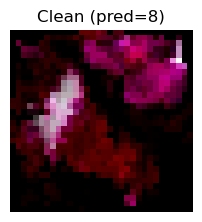

In [60]:
# Test : visualize the effect of FGSM on a specific image
# Base image, perturbation, and adversarial image for a specific epsilon value

idx = 20  # choose which image to display

for i, eps in enumerate(epsilon):
    print(f"\nExample {idx} with epsilon={eps}:")
    print("----------------------------------------")
    print(f"Clean predictions:", pred_clean[idx].item(), f"({ class_names[pred_clean[idx].item()]})")
    print(f"Adversarial predictions:", pred_adv_list[i][idx].item(), f"({ class_names[pred_adv_list[i][idx].item()]})")
    
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    show_image(images[idx], title=f"Clean (pred={pred_clean[idx].item()})")

    perturbation = adv_images_list[i][idx] - images[idx]
    #print(perturbation)
    print("max perturbation:", perturbation.abs().max().item())
    
    plt.subplot(1, 3, 2)
    show_image(perturbation, title="FGSM Perturbation")

    plt.subplot(1, 3, 3)
    show_image(adv_images_list[i][idx], title=f"Adversarial (pred={pred_adv_list[i][idx].item()})")

    plt.tight_layout()
    plt.show()


## 2.1 PGD Attack Implementation

In [43]:
# PGD Attack Implementation
# Apply an iterative version of FGSM

def pgd_attack(model, images, labels, epsilon=0.03, alpha=0.01, num_iter=5):
    model.eval()

    images = images.clone().detach().to(device)
    labels = labels.to(device)

    ori_images = images.clone().detach()

    for _ in range(num_iter):
        images.requires_grad = True

        outputs = model(images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        loss.backward()

        grad = images.grad.data
        images = images + alpha * grad.sign()

        # Project back into epsilon-ball
        eta = torch.clamp(images - ori_images, min=-epsilon, max=epsilon)
        images = ori_images + eta

        # Detach to avoid gradient accumulation
        images = images.detach()

    return images



PGD attack with alpha=0.001
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 8 (ship)
max |Δ|: 0.0050002336502075195


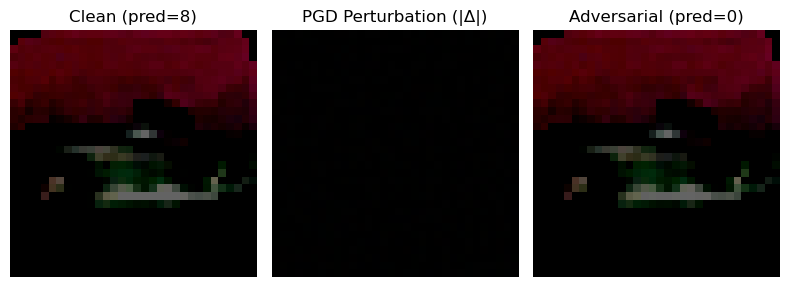

accuracy on PGD adversarial examples: 0.3125
accuracy on clean examples: 0.6875

PGD attack with alpha=0.005
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 8 (ship)
max |Δ|: 0.025000013411045074


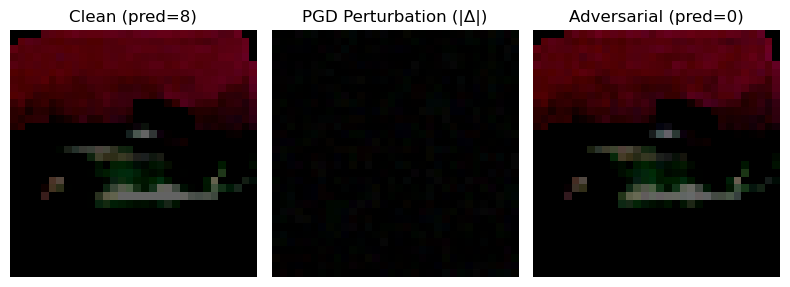

accuracy on PGD adversarial examples: 0.0312
accuracy on clean examples: 0.6875

PGD attack with alpha=0.01
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 8 (ship)
max |Δ|: 0.030000001192092896


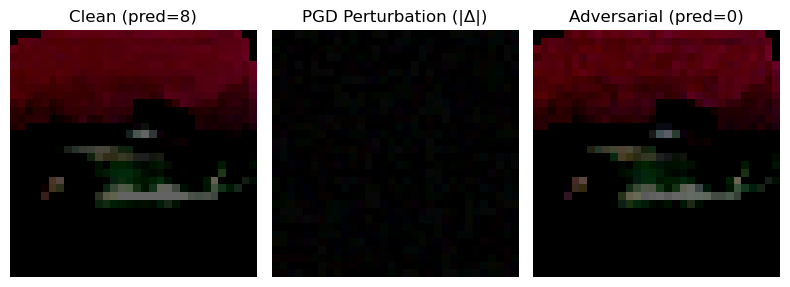

accuracy on PGD adversarial examples: 0.0000
accuracy on clean examples: 0.6875

PGD attack with alpha=0.02
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 8 (ship)
max |Δ|: 0.030000001192092896


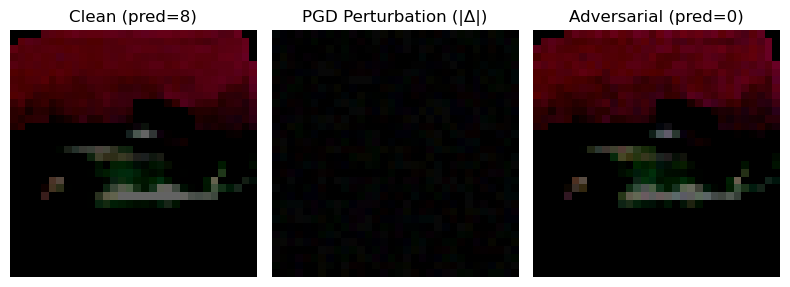

accuracy on PGD adversarial examples: 0.0000
accuracy on clean examples: 0.6875

PGD attack with alpha=0.03
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 8 (ship)
max |Δ|: 0.030000001192092896


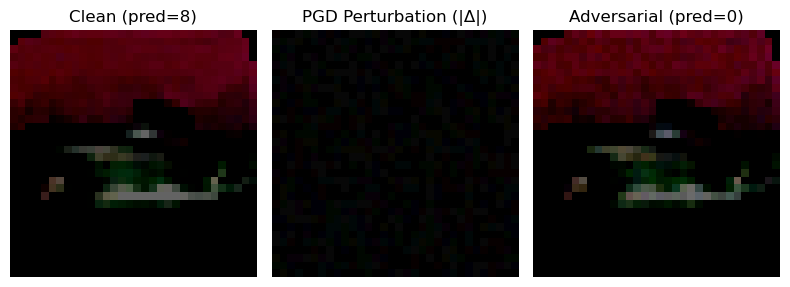

accuracy on PGD adversarial examples: 0.0000
accuracy on clean examples: 0.6875


In [ ]:
# Test PGD attack with different alpha values
for alpha in [0.001, 0.005, 0.01, 0.02, 0.03]:
    print(f"\nPGD attack with alpha={alpha}")
    pgd_images = pgd_attack(model, images, labels, epsilon=0.03, alpha=alpha, num_iter=5)
    pgd_outputs = model(pgd_images)
    _, pred_pgd = torch.max(pgd_outputs, 1)

    idx = 20  # choose which image to display

    print(f"PGD Adversarial predictions:", pred_pgd[idx].item(), f"({ class_names[pred_pgd[idx].item()]})")
    print(f"Initial prediction:", pred_clean[idx].item(), f"({ class_names[pred_clean[idx].item()]})")

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    show_image(images[idx], title=f"Clean (pred={pred_clean[idx].item()})")

    perturbation = pgd_images[idx] - images[idx]
    #print(perturbation)
    print("max :", perturbation.abs().max().item())

    plt.subplot(1, 3, 2)
    show_image(perturbation, title="PGD Perturbation")

    plt.subplot(1, 3, 3)
    show_image(pgd_images[idx], title=f"Adversarial (pred={pred_pgd[idx].item()})")

    plt.tight_layout()
    plt.show()

    print(f"accuracy on PGD adversarial examples: {accuracy_score(labels.cpu(), pred_pgd.cpu()):.4f}")
    print(f"accuracy on clean examples: {accuracy_clean:.4f}")

# 3. Data Poisoning Attacks (Training-Time Threats)
## 3.1 Label-Flipping Poisoning Experiment

In [50]:
import random

images, labels = next(iter(train_loader))

# Label poisoning function
def poison_labels(labels, poison_rate=0.1):
    labels = labels.clone().detach().to(device)
    n_poison = int(len(labels) * poison_rate)
    for i in random.sample(range(len(labels)), n_poison):
        labels[i] = random.randint(0, 9)
    
    return labels

for poison_rate in [0.05, 0.15, 0.5]:
    print(f"\nPoisoning labels with poison rate={poison_rate}")
    poisoned_labels = poison_labels(labels, poison_rate=poison_rate)
    print(f"Original labels: {labels[:20].cpu().numpy()}")
    print(f"Poisoned labels: {poisoned_labels[:20].cpu().numpy()}")



Poisoning labels with poison rate=0.05
Original labels: [2 3 6 2 0 8 6 6 8 3 8 8 2 4 4 4 4 1 2 3]
Poisoned labels: [2 3 6 7 0 8 6 6 8 3 8 8 2 4 4 4 4 1 2 3]

Poisoning labels with poison rate=0.15
Original labels: [2 3 6 2 0 8 6 6 8 3 8 8 2 4 4 4 4 1 2 3]
Poisoned labels: [2 3 6 2 0 8 6 6 9 0 8 8 2 4 4 4 4 1 2 3]

Poisoning labels with poison rate=0.5
Original labels: [2 3 6 2 0 8 6 6 8 3 8 8 2 4 4 4 4 1 2 3]
Poisoned labels: [2 3 6 8 0 4 6 6 4 3 8 0 0 4 4 2 4 8 3 3]


In [ ]:
### Recreate an empty model for this training
poisoned_model = SimpleCNN(num_classes=10)

In [56]:
### Training with poisoned labels

def train_model_with_label_poisoning(model, train_loader, val_loader, num_epochs=50, poison_rate=0.05):

    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            poisoned_labels = poison_labels(labels, poison_rate=0.05)  # Poison 5% of the labels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, poisoned_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        class_correct = defaultdict(int)
        class_total = defaultdict(int)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for i in range(len(labels)):
                    label = labels[i].item()
                    pred = predicted[i].item()
                    if label == pred:
                        class_correct[label] += 1
                    class_total[label] += 1

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        for class_idx in range(len(class_total)):
            accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
            print(f"Validation Accuracy for class {class_idx}: {accuracy:.2f}%")

    return model


In [ ]:
poisoned_model = train_model_with_label_poisoning(poisoned_model, train_loader, val_loader, num_epochs=50, poison_rate=0.05)

Epoch 1/50, Train Loss: 1.4597, Val Loss: 1.3796, Val Accuracy: 50.28%
Validation Accuracy for class 0: 58.27%
Validation Accuracy for class 1: 78.27%
Validation Accuracy for class 2: 48.40%
Validation Accuracy for class 3: 27.60%
Validation Accuracy for class 4: 35.33%
Validation Accuracy for class 5: 39.73%
Validation Accuracy for class 6: 49.60%
Validation Accuracy for class 7: 54.80%
Validation Accuracy for class 8: 64.00%
Validation Accuracy for class 9: 46.80%
Epoch 2/50, Train Loss: 1.4532, Val Loss: 1.3386, Val Accuracy: 51.41%
Validation Accuracy for class 0: 69.07%
Validation Accuracy for class 1: 76.13%
Validation Accuracy for class 2: 44.40%
Validation Accuracy for class 3: 14.80%
Validation Accuracy for class 4: 49.07%
Validation Accuracy for class 5: 42.13%
Validation Accuracy for class 6: 61.20%
Validation Accuracy for class 7: 55.60%
Validation Accuracy for class 8: 50.80%
Validation Accuracy for class 9: 50.93%
Epoch 3/50, Train Loss: 1.4454, Val Loss: 1.3321, Val Accu

In [64]:
# Save the trained model
torch.save(poisoned_model.state_dict(), 'poisoned_cnn_5.pth')
print("Model saved as poisoned_cnn_5%.pth")

Model saved as poisoned_cnn_5%.pth


In [ ]:
### Another empty model
poisoned_model2 = SimpleCNN(num_classes=10)

poisoned_model2 = train_model_with_label_poisoning(poisoned_model2, train_loader, val_loader, num_epochs=50, poison_rate=0.15)

# Save the trained model
torch.save(poisoned_model2.state_dict(), 'poisoned_cnn_15.pth')
print("Model saved as poisoned_cnn_15%.pth")

Epoch 1/10, Train Loss: 2.0602, Val Loss: 1.8280, Val Accuracy: 33.27%
Validation Accuracy for class 0: 38.13%
Validation Accuracy for class 1: 58.27%
Validation Accuracy for class 2: 22.40%
Validation Accuracy for class 3: 8.40%
Validation Accuracy for class 4: 12.27%
Validation Accuracy for class 5: 41.73%
Validation Accuracy for class 6: 40.80%
Validation Accuracy for class 7: 22.00%
Validation Accuracy for class 8: 42.27%
Validation Accuracy for class 9: 46.40%


KeyboardInterrupt: 

In [25]:
# Load the trained model
poisoned_model = SimpleCNN(num_classes=10)
poisoned_model.load_state_dict(torch.load('poisoned_cnn_5.pth'))

poisoned_model2 = SimpleCNN(num_classes=10)
poisoned_model2.load_state_dict(torch.load('poisoned_cnn_15.pth'))

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
poisoned_model.to(device)
poisoned_model2.to(device)

poisoned_model.eval()
poisoned_model2.eval()

# Evaluate on the test set

print("\nEvaluating original model:")
evaluate_model(model, test_loader)  

print("\nEvaluating poisoned model (5%):")
evaluate_model(poisoned_model, test_loader)

print("\nEvaluating poisoned model (15%):")
evaluate_model(poisoned_model2, test_loader)



Evaluating original model:
Test Accuracy: 54.91%
Test Accuracy for class 0: 52.58%
Test Accuracy for class 1: 64.02%
Test Accuracy for class 2: 41.31%
Test Accuracy for class 3: 33.24%
Test Accuracy for class 4: 51.52%
Test Accuracy for class 5: 47.91%
Test Accuracy for class 6: 73.15%
Test Accuracy for class 7: 47.13%
Test Accuracy for class 8: 72.21%
Test Accuracy for class 9: 63.66%

Evaluating poisoned model (5%):
Test Accuracy: 51.65%
Test Accuracy for class 0: 63.59%
Test Accuracy for class 1: 62.17%
Test Accuracy for class 2: 35.74%
Test Accuracy for class 3: 24.21%
Test Accuracy for class 4: 51.65%
Test Accuracy for class 5: 46.70%
Test Accuracy for class 6: 68.76%
Test Accuracy for class 7: 47.53%
Test Accuracy for class 8: 56.81%
Test Accuracy for class 9: 56.96%

Evaluating poisoned model (15%):
Test Accuracy: 49.41%
Test Accuracy for class 0: 55.84%
Test Accuracy for class 1: 57.28%
Test Accuracy for class 2: 23.09%
Test Accuracy for class 3: 26.95%
Test Accuracy for class

# 4. Defenses and Robustness Trade-Offs
## 4.1 Adversarial Training Defense 




In [ ]:
# We made a function from the code to make later use easier
def train_model_adversarial(model, train_loader, val_loader, num_epochs=50, epsilon=0.03):

    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            # ---------- Generate FGSM ----------
            model.eval()                     
            inputs.requires_grad = True

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            model.zero_grad()
            loss.backward()

            fgsm_images = fgsm_attack(inputs, epsilon, inputs.grad.data)
            #fgsm_images = torch.clamp(fgsm_images, 0, 1)

            # ---------- Train on both ----------
            model.train()

            combined_inputs = torch.cat([inputs.detach(), fgsm_images.detach()])
            combined_labels = torch.cat([labels, labels])


            optimizer.zero_grad()
            outputs = model(combined_inputs)
            loss = criterion(outputs, combined_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        class_correct = defaultdict(int)
        class_total = defaultdict(int)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for i in range(len(labels)):
                    label = labels[i].item()
                    pred = predicted[i].item()
                    if label == pred:
                        class_correct[label] += 1
                    class_total[label] += 1

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        for class_idx in range(len(class_total)):
            accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
            print(f"Validation Accuracy for class {class_idx}: {accuracy:.2f}%")

    return model

In [27]:
adversarial_model = SimpleCNN(num_classes=10)

adversarial_model = train_model_adversarial(adversarial_model, train_loader, val_loader, num_epochs=10, epsilon=0.03)

Epoch 1/10, Train Loss: 2.2150, Val Loss: 1.9908, Val Accuracy: 28.63%
Validation Accuracy for class 0: 32.34%
Validation Accuracy for class 1: 37.09%
Validation Accuracy for class 2: 10.46%
Validation Accuracy for class 3: 10.29%
Validation Accuracy for class 4: 8.24%
Validation Accuracy for class 5: 49.93%
Validation Accuracy for class 6: 40.32%
Validation Accuracy for class 7: 17.33%
Validation Accuracy for class 8: 37.70%
Validation Accuracy for class 9: 41.93%
Epoch 2/10, Train Loss: 2.0624, Val Loss: 1.8428, Val Accuracy: 33.47%
Validation Accuracy for class 0: 36.23%
Validation Accuracy for class 1: 55.03%
Validation Accuracy for class 2: 31.79%
Validation Accuracy for class 3: 2.54%
Validation Accuracy for class 4: 6.98%
Validation Accuracy for class 5: 52.03%
Validation Accuracy for class 6: 56.59%
Validation Accuracy for class 7: 28.67%
Validation Accuracy for class 8: 44.73%
Validation Accuracy for class 9: 20.77%
Epoch 3/10, Train Loss: 1.9995, Val Loss: 1.7957, Val Accurac

In [28]:
# Save the trained model
torch.save(adversarial_model.state_dict(), 'adversarial_cnn.pth')
print("Model saved as adversarial_cnn.pth")

Model saved as adversarial_cnn.pth


In [30]:
# Load the trained model
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('adversarial_cnn.pth'))

model.to(device)


## Apply FGSM attack on a sample from the test set

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
# Enable gradient computation
images.requires_grad = True
# Forward pass
outputs = model(images)
# Compute loss
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
# Backward pass
model.zero_grad()
loss.backward()
# Collect gradient of input
data_grad = images.grad.data
# Generate adversarial batches
epsilon = [0, 0.005, 0.01, 0.03, 0.05, 0.06]  # You can experiment with different epsilon values
adv_outputs = []
adv_images_list = []

for eps in epsilon:
    adv_images = fgsm_attack(images, eps, data_grad)
    adv_images_list.append(adv_images)
    # Re-classify adversarial examples
    adv_outputs.append(model(adv_images))

# Compare predictions
pred_adv_list = []
_, pred_clean = torch.max(outputs, 1)
for i in range(len(epsilon)):
    _, pred_adv = torch.max(adv_outputs[i], 1)
    pred_adv_list.append(pred_adv)

print("Clean predictions:", pred_clean[:5])
for i, eps in enumerate(epsilon):
    print(f"Adversarial predictions (epsilon={eps}):", pred_adv_list[i][:5])

Clean predictions: tensor([7, 6, 8, 5, 5], device='cuda:0')
Adversarial predictions (epsilon=0): tensor([7, 6, 8, 5, 5], device='cuda:0')
Adversarial predictions (epsilon=0.005): tensor([7, 6, 8, 5, 5], device='cuda:0')
Adversarial predictions (epsilon=0.01): tensor([7, 6, 8, 5, 5], device='cuda:0')
Adversarial predictions (epsilon=0.03): tensor([7, 6, 8, 5, 5], device='cuda:0')
Adversarial predictions (epsilon=0.05): tensor([7, 6, 8, 5, 5], device='cuda:0')
Adversarial predictions (epsilon=0.06): tensor([7, 6, 8, 5, 9], device='cuda:0')


In [ ]:
from sklearn.metrics import accuracy_score

# Accuracy on clean and adversarial examples after adversarial training

accuracy_clean = accuracy_score(labels.cpu(), pred_clean.cpu())
accuracy_adv = []
for i in range(len(epsilon)):
    accuracy_adv.append(accuracy_score(labels.cpu(), pred_adv_list[i].cpu()))

print (f"Accuracy on clean examples: {accuracy_clean:.4f}")
for i, eps in enumerate(epsilon):
    print(f"Accuracy on adversarial examples (epsilon={eps}): {accuracy_adv[i]:.4f}")

Accuracy on clean examples: 0.3750
Accuracy on adversarial examples (epsilon=0): 0.3750
Accuracy on adversarial examples (epsilon=0.005): 0.3125
Accuracy on adversarial examples (epsilon=0.01): 0.3125
Accuracy on adversarial examples (epsilon=0.03): 0.2188
Accuracy on adversarial examples (epsilon=0.05): 0.2188
Accuracy on adversarial examples (epsilon=0.06): 0.1875
